# **대구 교통 사고 피해 예측 AI 경진대회**

### 1. 분석 개요
이동수단의 발달에 따라 다양한 유형의 교통사고들이 계속 발생하고 있습니다. 이러한 사고의 원인을 규명하고 사고율을 낮추기 위해 시공간 정보로부터 사고위험도(ECLO)를 예측하는 AI 알고리즘 발굴을 목표로 합니다.

### 2. 주최 / 주관 / 운영
- 주최: 산업통상자원부, 대구광역시
- 주관: 한국자동차연구원, 대구디지털혁신진흥원
- 운영: 데이콘

### 3. 핵심 전략
- 변수들의 이상치 값을 제외
- 제공되는 외부데이터인 보안등 / 어린이보호구역 / CCTV / 주차장 정보를 전처리해서 예측 변수로 활용
- 또한, 사고다발지역 정보를 활용하여 예측 변수로 활용
- 변수들의 상관계수가 0.7 이상인 경우 제외
- 유의한 변수들을 활용하여 성능이 비교적 좋은 트리기반 모델인 XGB와 CatBoost를 비교하여 최종 모델 선택

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,901 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121666 files and dire

In [6]:
import pandas as pd
import statsmodels.api as sm
import geopandas as gpd
import pyproj
from fiona.crs import from_epsg
import folium
from sklearn.preprocessing import LabelEncoder
import chardet

from collections import Counter
import re

from collections import defaultdict
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.path import Path
%matplotlib inline

plt.rc('font', family='NanumBarunGothic')

import os
import random
import warnings
warnings.filterwarnings('ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

### 데이터 로드

In [18]:
dpath = '/content/drive/MyDrive/hs/2. ExampleData/dm_dacon_daegu_data/data/open/'
# 학습데이터
train = pd.read_csv(dpath + 'train.csv')
# 테스트데이터
test = pd.read_csv(dpath + 'test.csv')

In [19]:
display(f"train : {train.iloc[0]['사고일시']} ~ {train.iloc[-1]['사고일시']}")
display(f"test : {test.iloc[0]['사고일시']} ~ {test.iloc[-1]['사고일시']}")

'train : 2019-01-01 00 ~ 2021-12-31 23'

'test : 2022-01-01 01 ~ 2022-12-31 21'

In [20]:
display(train.head(5))
display(test.head(5))

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차


In [22]:
train.사고유형.unique()

array(['차대사람', '차대차', '차량단독'], dtype=object)

### 데이터 전처리

In [6]:
### train / test 전처리

# 변수형 변경
import re
def extract_and_convert_to_int(data):
    numbers = re.findall(r'\d+', str(data))
    return int(numbers[0]) if numbers else np.nan

train['가해운전자 연령'] = train['가해운전자 연령'].apply(extract_and_convert_to_int)
train['피해운전자 연령'] = train['피해운전자 연령'].apply(extract_and_convert_to_int)

# 날짜 변수 처리
import datetime

## train
train['acci_date'] = pd.to_datetime(train['사고일시'])
train['년'] = train['acci_date'].dt.year
train['월'] = train['acci_date'].dt.month
train['시간'] = train['acci_date'].dt.hour
train = train.drop(columns=['사고일시', 'acci_date'])

## test
test['acci_date'] = pd.to_datetime(test['사고일시'])
test['년'] = test['acci_date'].dt.year
test['월'] = test['acci_date'].dt.month
test['시간'] = test['acci_date'].dt.hour
test = test.drop(columns=['사고일시', 'acci_date'])


# 시군구 처리
# 예를 들어 '대구광역시 중구 대신동'을 대구광역시 / 중구 / 대신동으로 시군구 각 변수로 분리함
location_pattern = r'(\S+) (\S+) (\S+)'

## train
train[['도시', '구', '동']] = train['시군구'].str.extract(location_pattern)
train = train.drop(columns=['시군구'])

## test
test[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
test = test.drop(columns=['시군구'])


# 도로형태 처리
# 예를 들어 '단일로 - 기타' -> 단일로 / 기타로 도로형태1, 도로형태2로 분리함
road_pattern = r'(.+) - (.+)'

## train
train[['도로형태1','도로형태2']] = train['도로형태'].str.extract(road_pattern)
train = train.drop(columns=['도로형태'])

## test
test[['도로형태1','도로형태2']] = test['도로형태'].str.extract(road_pattern)
test = test.drop(columns=['도로형태'])

In [7]:
display(train.head(5))
display(test.head(5))

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,...,부상자수,ECLO,년,월,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51.0,...,0,5,2019,1,0,대구광역시,중구,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,39.0,...,0,3,2019,1,0,대구광역시,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70.0,...,0,3,2019,1,1,대구광역시,수성구,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49.0,...,0,5,2019,1,2,대구광역시,북구,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30.0,...,0,3,2019,1,4,대구광역시,동구,신암동,단일로,기타


,ID,요일,기상상태,노면상태,사고유형,년,월,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,대구광역시,수성구,상동,교차로,교차로안
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,대구광역시,수성구,지산동,단일로,기타
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,4,대구광역시,수성구,수성동2가,교차로,교차로안
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,4,대구광역시,수성구,신매동,단일로,기타
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,6,대구광역시,달서구,감삼동,교차로,교차로안


### EDA


- 2019년 이후로 사고위험지수(ECLO)가 낮아지고 있습니다.
- 3월,11월에 사고위험지수가 높았습니다.
- 00~05시 새벽시간대에 사고위험지수가 높았습니다.
- 평일보다 주말에 사고위험지수가 높았습니다.
- 그러나 이상치가 존재하여 중앙값이 보이지 않으므로 이상치를 제거하는 것도 좋을 것으로 보입니다.

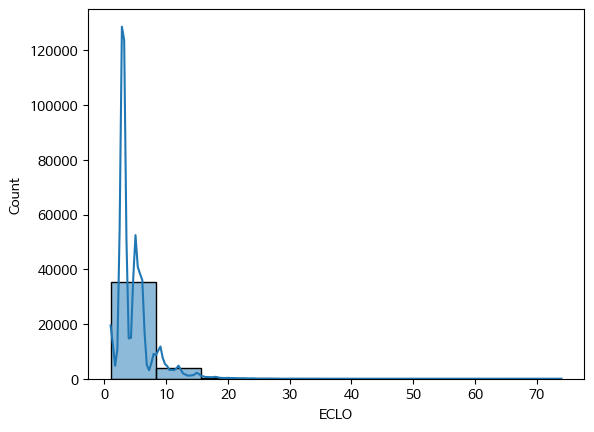

In [ ]:
sns.histplot(train['ECLO'], bins=10, kde=True)
plt.show()

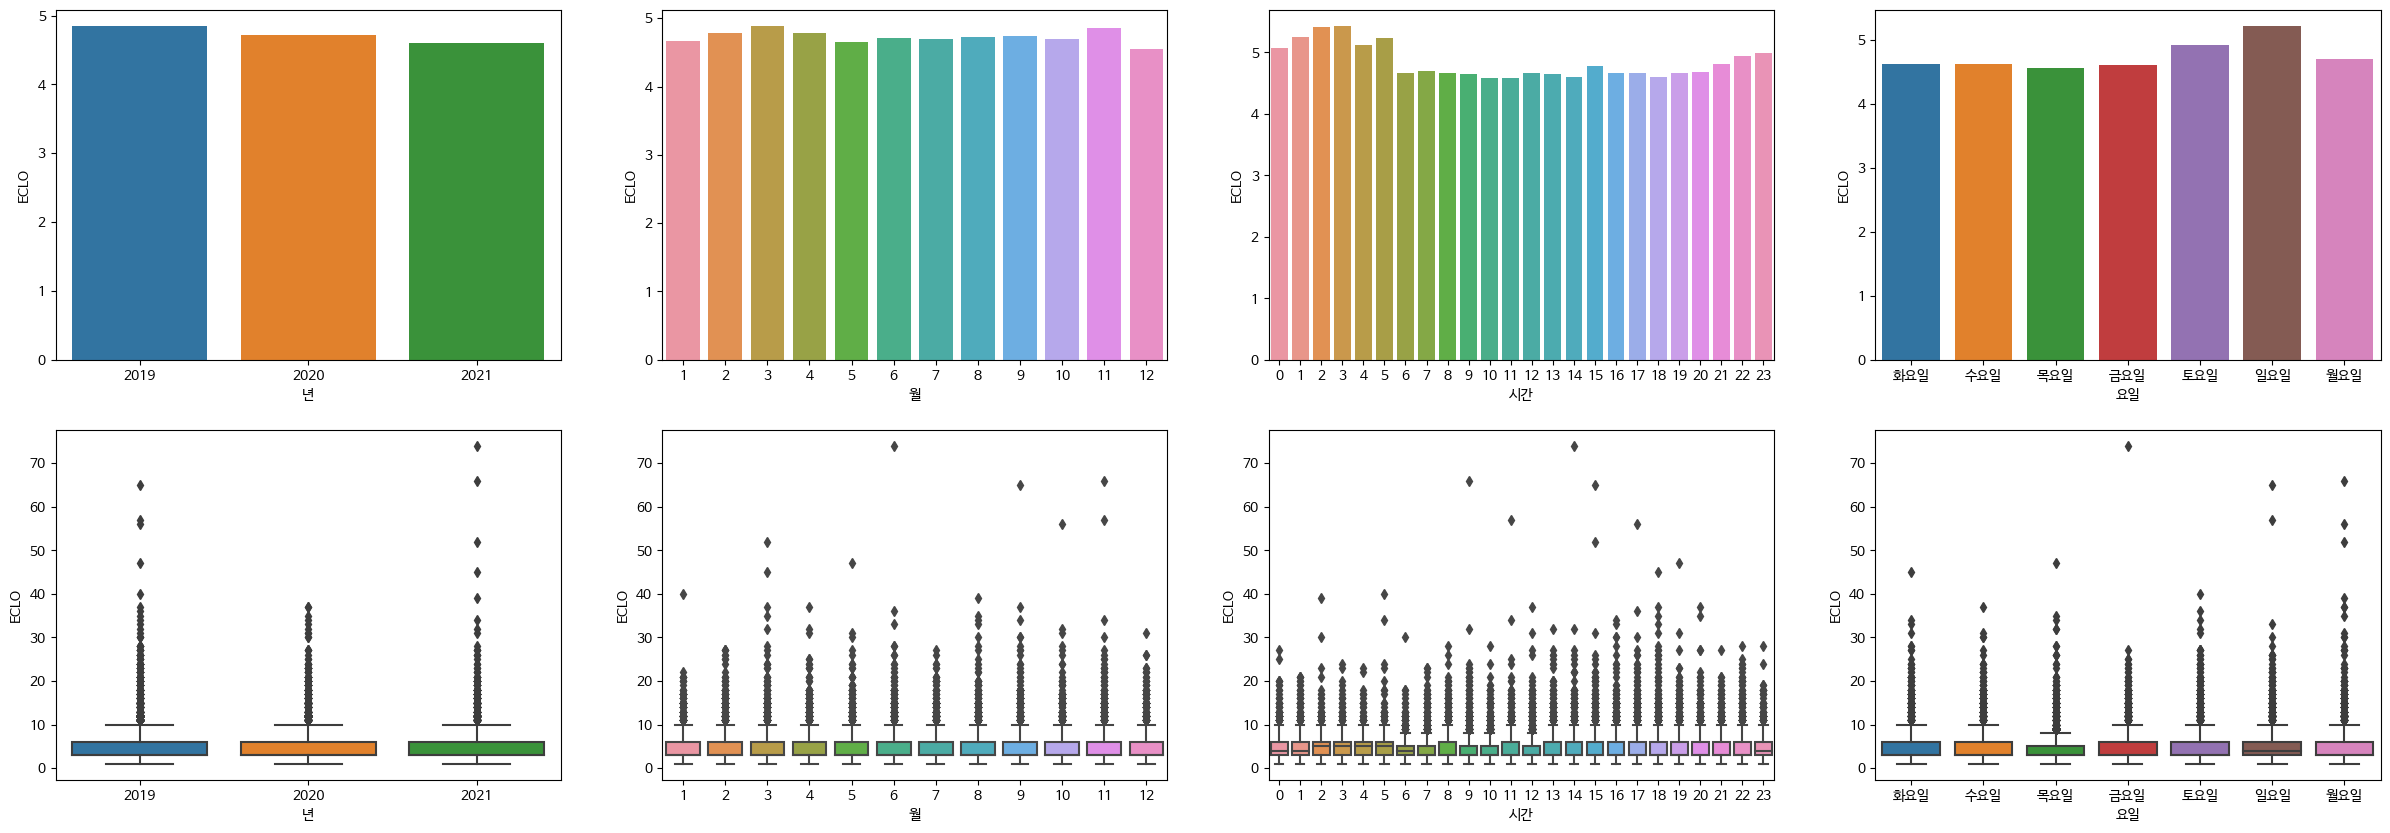

In [ ]:
fig,ax = plt.subplots(2,4,figsize=(30, 10))
sns.barplot(x=train['년'], y=train['ECLO'], ci=None ,ax=ax[0,0])
sns.barplot(x=train['월'], y=train['ECLO'], ci=None ,ax=ax[0,1])
sns.barplot(x=train['시간'], y=train['ECLO'], ci=None ,ax=ax[0,2])
sns.barplot(x=train['요일'], y=train['ECLO'], ci=None ,ax=ax[0,3])

sns.boxplot(x=train['년'], y=train['ECLO'], ax=ax[1,0])
sns.boxplot(x=train['월'], y=train['ECLO'], ax=ax[1,1])
sns.boxplot(x=train['시간'], y=train['ECLO'], ax=ax[1,2])
sns.boxplot(x=train['요일'], y=train['ECLO'], ax=ax[1,3])
plt.show()

### train EDA - 이상치 제거


In [8]:
## 이상치 제거
from scipy import stats

# Z-Score 계산
z_scores = stats.zscore(train['ECLO'])

threshold = 3
df_no_outliers = train[(z_scores < threshold) & (z_scores > -threshold)]

In [9]:
display(df_no_outliers.shape)
display(df_no_outliers.head(5))

(38829, 28)

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,...,부상자수,ECLO,년,월,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51.0,...,0,5,2019,1,0,대구광역시,중구,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,39.0,...,0,3,2019,1,0,대구광역시,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70.0,...,0,3,2019,1,1,대구광역시,수성구,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49.0,...,0,5,2019,1,2,대구광역시,북구,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30.0,...,0,3,2019,1,4,대구광역시,동구,신암동,단일로,기타


In [ ]:
def categorize_age(age):
    if age < 18:
        return 'Under 18'
    elif 18 <= age < 30:
        return '18-29'
    elif 30 <= age < 40:
        return '30-39'
    elif 40 <= age < 50:
        return '40-49'
    else:
        return '50 and above'

# 예시
age = 25
category = categorize_age(age)

- 2021년 사고위험지수가 가장 낮았습니다.
- 6월, 9월, 10월, 12월에서 사고위험지수가 낮았습니다.
- 밤-새벽 시간대에서 사고위험지수가 높지만, 오후 3시경에도 높은 것으로 나타났습니다.

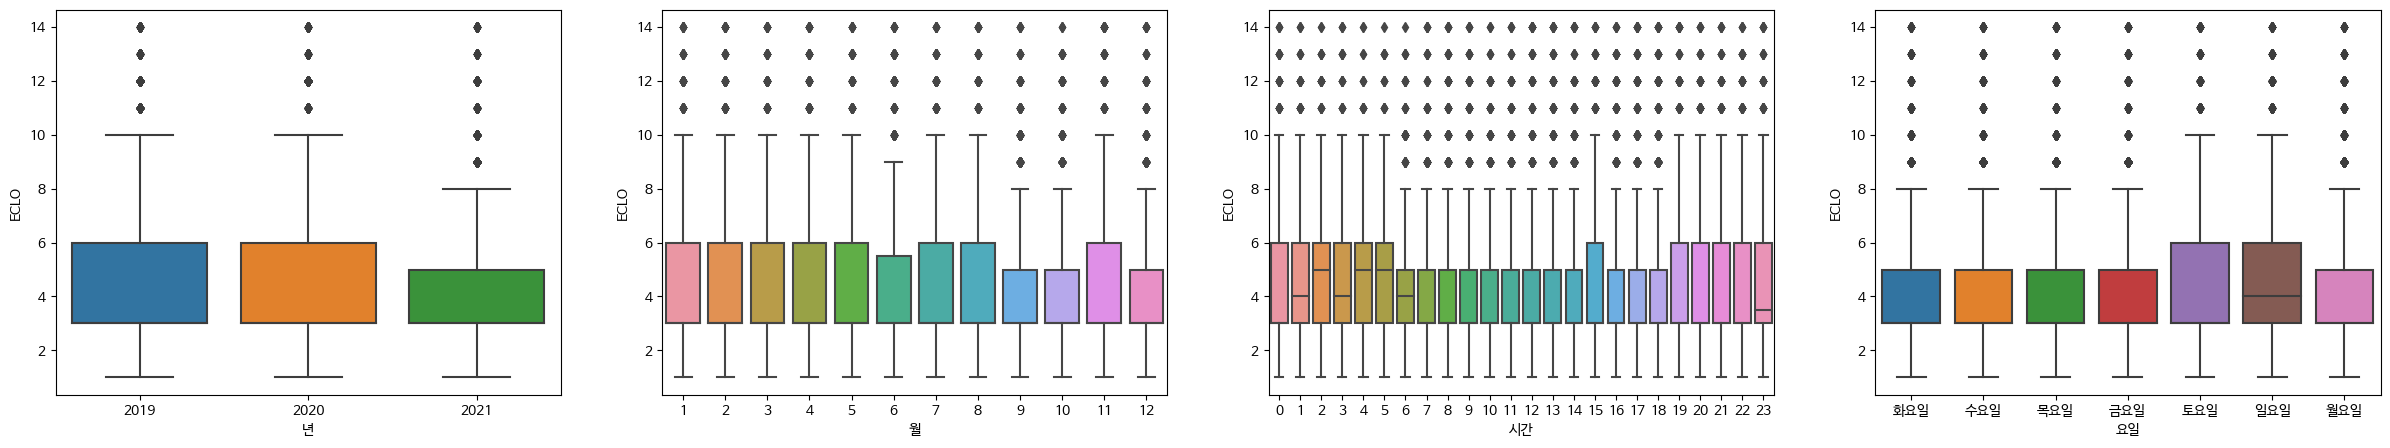

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(30, 5))

sns.boxplot(x=df_no_outliers['년'], y=df_no_outliers['ECLO'], ax=ax[0])
sns.boxplot(x=df_no_outliers['월'], y=df_no_outliers['ECLO'], ax=ax[1])
sns.boxplot(x=df_no_outliers['시간'], y=df_no_outliers['ECLO'], ax=ax[2])
sns.boxplot(x=df_no_outliers['요일'], y=df_no_outliers['ECLO'], ax=ax[3])
plt.show()

- 대구 달서구 / 수성구 / 동구 / 달성군에서 사고위험지수가 가장 높았습니다.
- 기상상태가 맑음 / 기타 / 비 / 안개 / 눈 에서 사고위험지수가 높았습니다.
- 노면상태가 건조 / 젖음,습기 / 서리,결빙 / 침수에서 사고위험지수가 높았습니다.
- 도로형태가 교차로 일때 사고위험지수가 높았습니다.


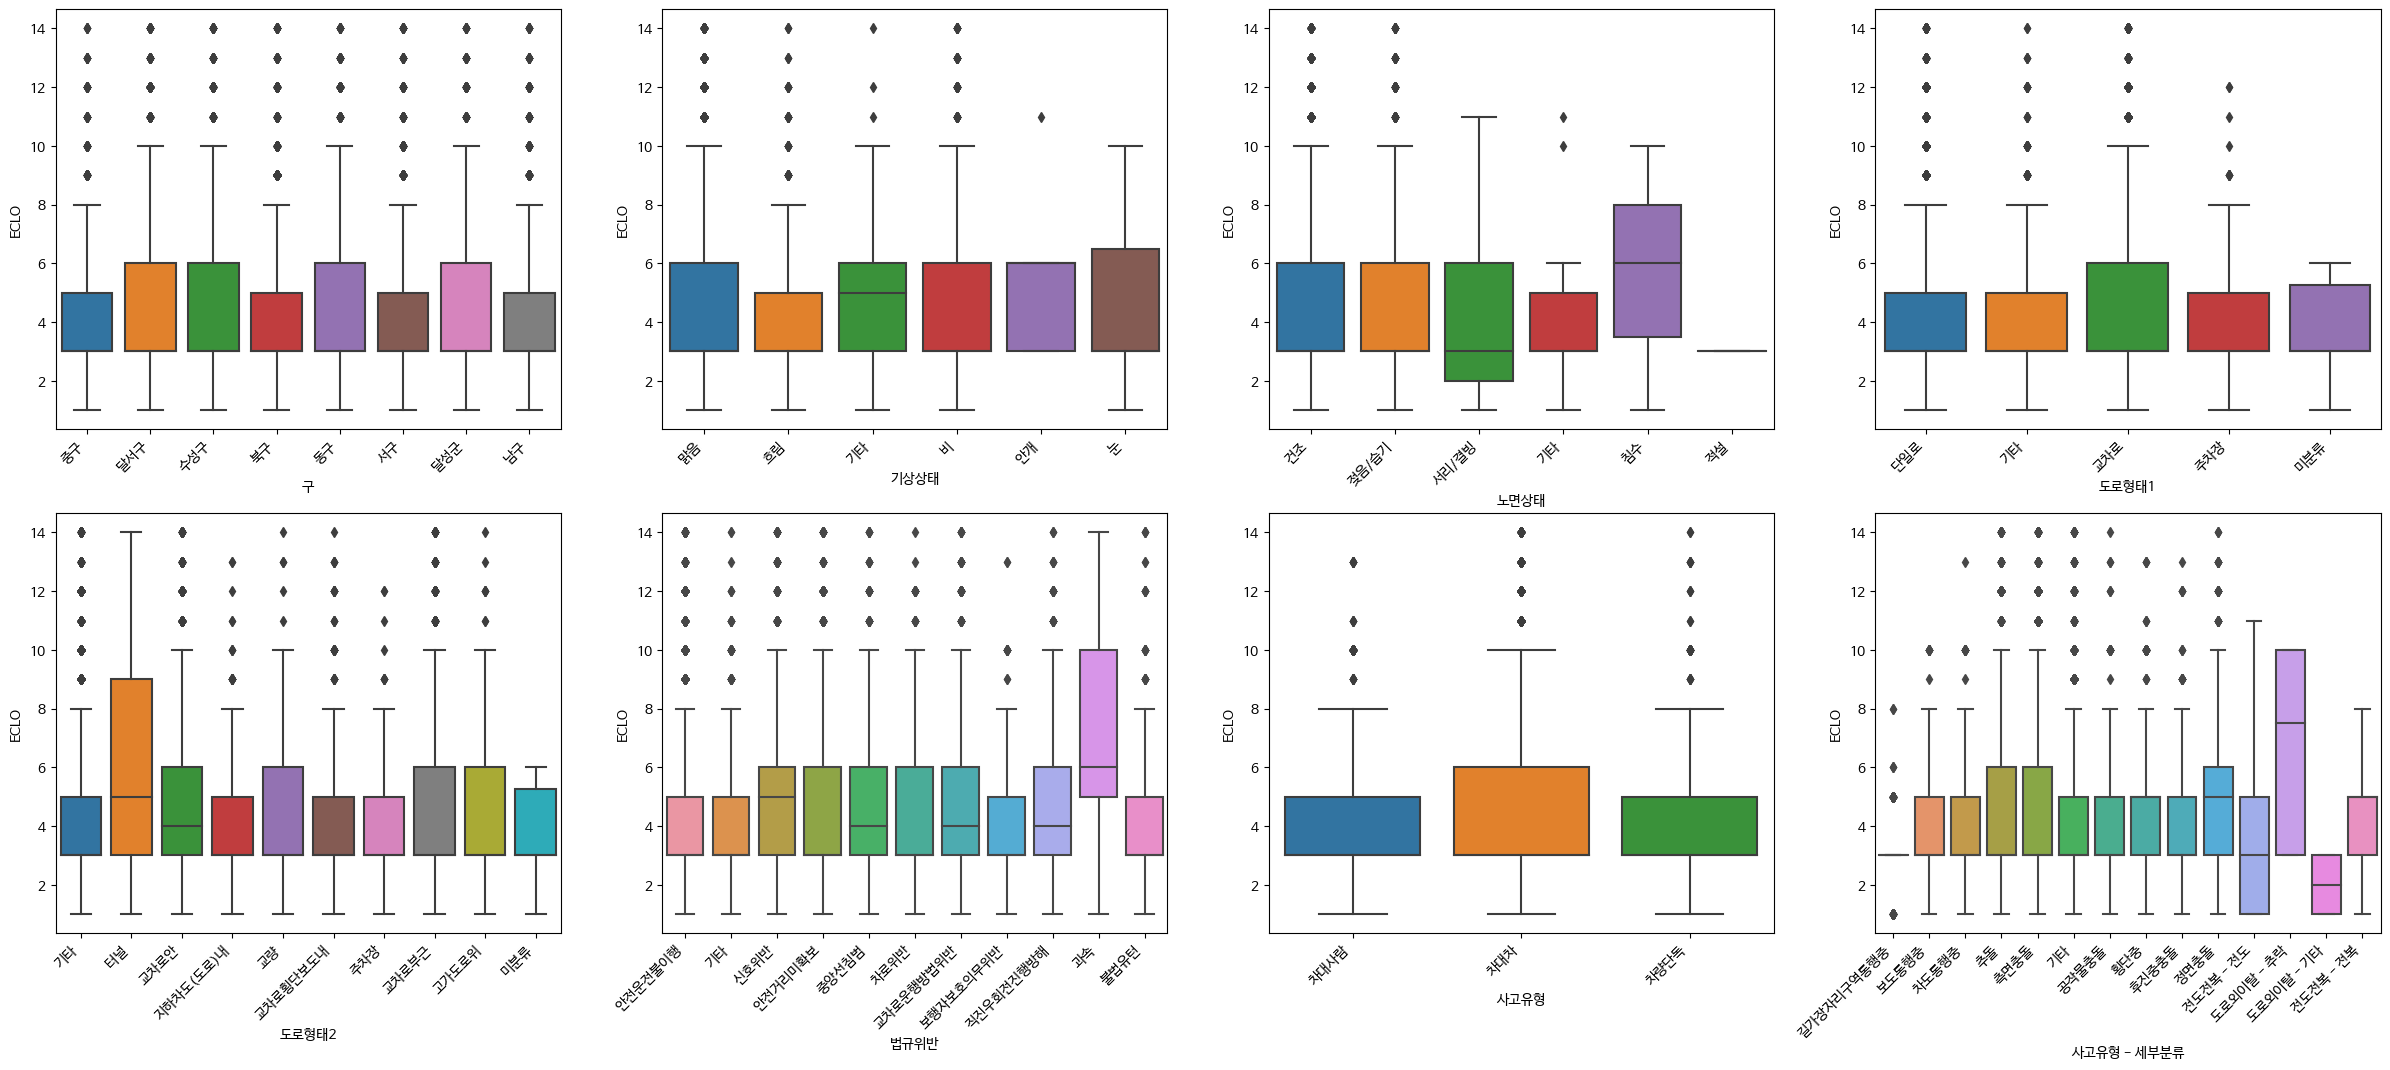

In [10]:
fig,ax = plt.subplots(2,4,figsize=(30, 12))

p = sns.boxplot(x=df_no_outliers['구'], y=df_no_outliers['ECLO'], ax=ax[0,0])
p.set_xticklabels(p.get_xticklabels(), rotation=45, ha='right')
p = sns.boxplot(x=df_no_outliers['기상상태'], y=df_no_outliers['ECLO'], ax=ax[0,1])
p.set_xticklabels(p.get_xticklabels(), rotation=45, ha='right')
p = sns.boxplot(x=df_no_outliers['노면상태'], y=df_no_outliers['ECLO'], ax=ax[0,2])
p.set_xticklabels(p.get_xticklabels(), rotation=45, ha='right')
p = sns.boxplot(x=df_no_outliers['도로형태1'], y=df_no_outliers['ECLO'], ax=ax[0,3])
p.set_xticklabels(p.get_xticklabels(), rotation=45, ha='right')
p = sns.boxplot(x=df_no_outliers['도로형태2'], y=df_no_outliers['ECLO'], ax=ax[1,0])
p.set_xticklabels(p.get_xticklabels(), rotation=45, ha='right')
p = sns.boxplot(x=df_no_outliers['법규위반'], y=df_no_outliers['ECLO'], ax=ax[1,1])
p.set_xticklabels(p.get_xticklabels(), rotation=45, ha='right')
p = sns.boxplot(x=df_no_outliers['사고유형'], y=df_no_outliers['ECLO'], ax=ax[1,2])
p.set_xticklabels(p.get_xticklabels(), rotation=45, ha='right')
p = sns.boxplot(x=df_no_outliers['사고유형 - 세부분류'], y=df_no_outliers['ECLO'], ax=ax[1,3])
p.set_xticklabels(p.get_xticklabels(), rotation=45, ha='right')

plt.show()

- 기상상태가 눈일때, 그리고 노면상태가 침수일때 위험지수가 눈에 띄게 높았습니다. 따라서 계절성과 추세성을 고려한 모델링이 필요할 것으로 생각하였습니다.

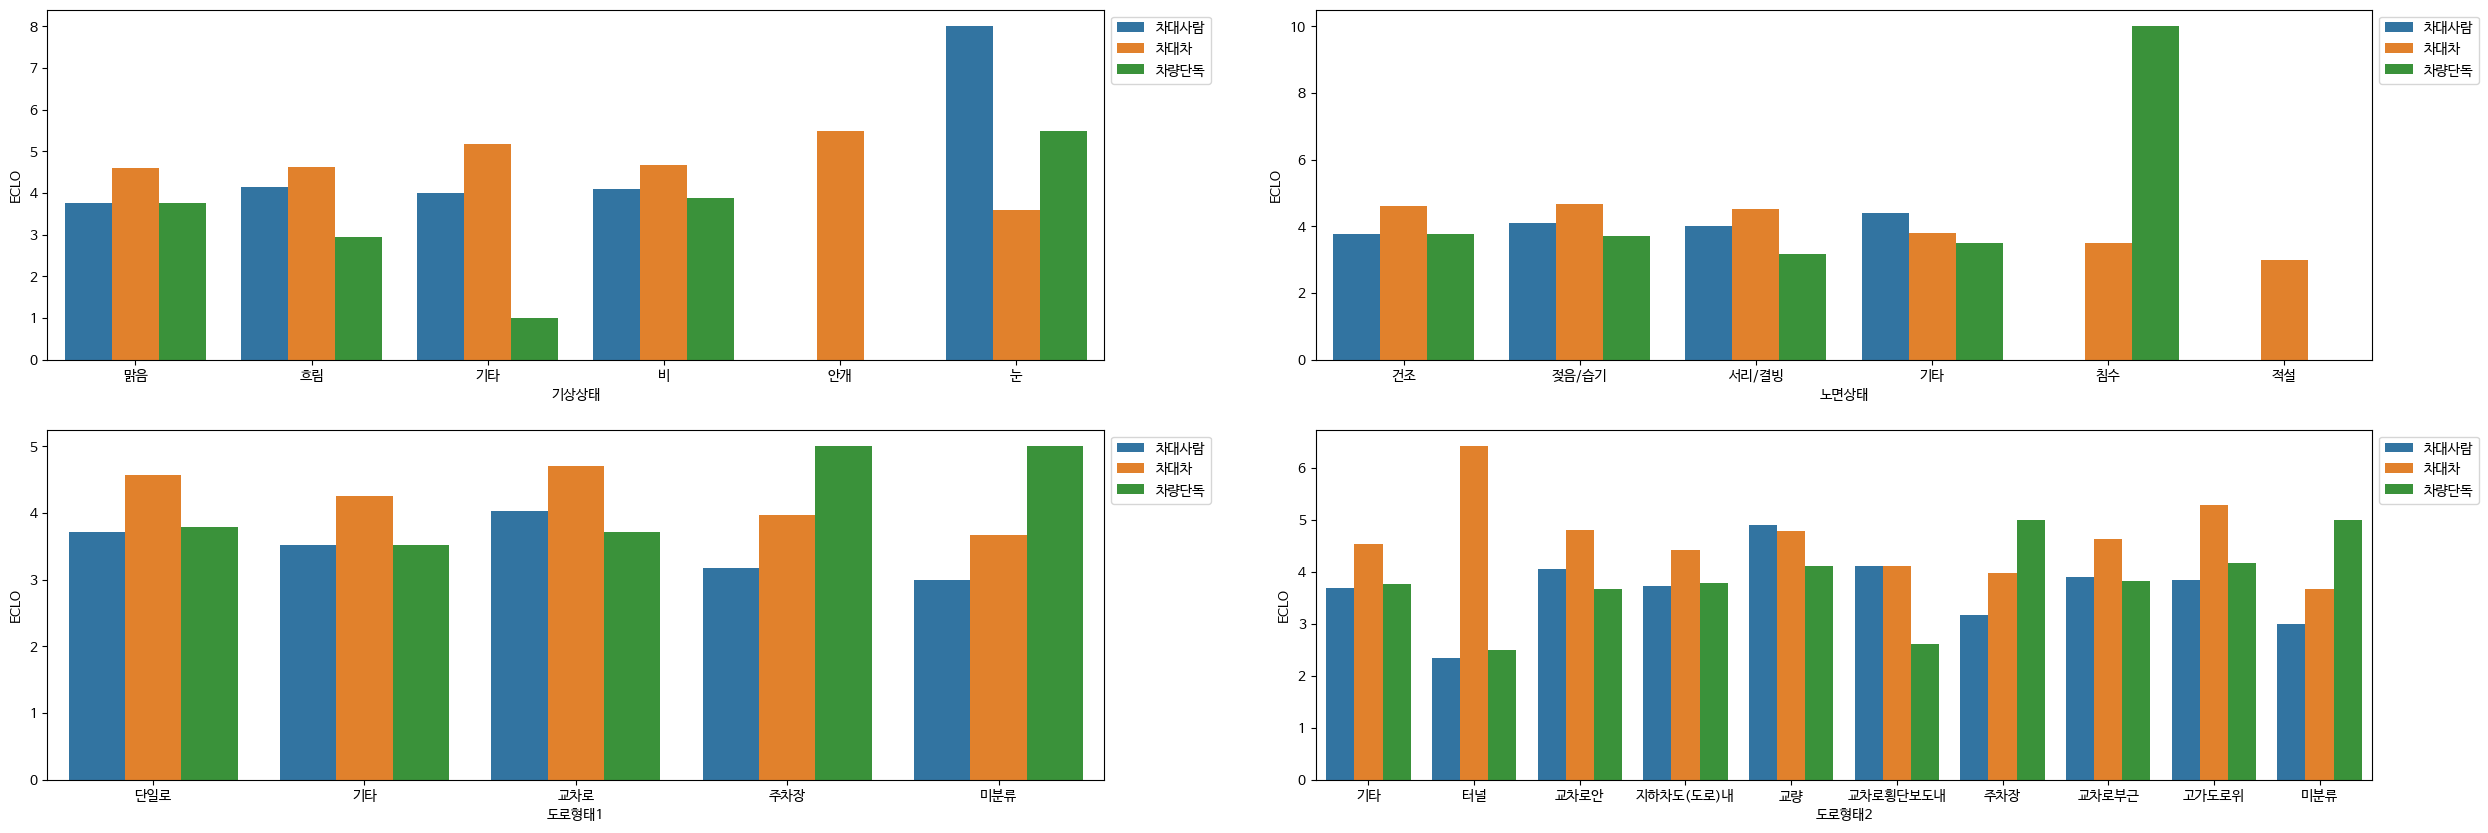

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(30, 10))
p = sns.barplot(x=df_no_outliers['기상상태'], y=df_no_outliers['ECLO'], hue = df_no_outliers['사고유형'], ci=None, ax=ax[0,0])
ax[0,0].legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.barplot(x=df_no_outliers['노면상태'], y=df_no_outliers['ECLO'], hue = df_no_outliers['사고유형'], ci=None, ax=ax[0,1])
ax[0,1].legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.barplot(x=df_no_outliers['도로형태1'], y=df_no_outliers['ECLO'], hue = df_no_outliers['사고유형'], ci=None, ax=ax[1,0])
ax[1,0].legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.barplot(x=df_no_outliers['도로형태2'], y=df_no_outliers['ECLO'], hue = df_no_outliers['사고유형'], ci=None, ax=ax[1,1])
ax[1,1].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### 외부 데이터 - 보안등 / 어린이보호구역 / CCTV / 주차장


In [ ]:
dpath = '/content/drive/MyDrive/hs/2. ExampleData/dm_dacon_daegu_data/data/open/'


with open(dpath + 'external_open/대구 CCTV 정보.csv', 'rb') as f:
    cctv_encode = chardet.detect(f.read())

with open(dpath + 'external_open/대구 보안등 정보.csv', 'rb') as f:
    protect_encode = chardet.detect(f.read())

with open(dpath + 'external_open/대구 어린이 보호 구역 정보.csv', 'rb') as f:
    child_encode = chardet.detect(f.read())

with open(dpath + 'external_open/대구 주차장 정보.csv', 'rb') as f:
    parking_encode = chardet.detect(f.read())


cctv_org = pd.read_csv(dpath + '/external_open/대구 CCTV 정보.csv', encoding=cctv_encode['encoding'])
protect_org = pd.read_csv(dpath + '/external_open/대구 보안등 정보.csv', encoding=protect_encode['encoding'], low_memory=False)
child_org = pd.read_csv(dpath + '/external_open/대구 어린이 보호 구역 정보.csv', encoding=child_encode['encoding'])
parking_org = pd.read_csv(dpath + '/external_open/대구 주차장 정보.csv', encoding=parking_encode['encoding'])

In [ ]:
cctv_df = cctv_org.copy()
protect_df = protect_org.copy()
child_df = child_org.copy()
parking_df = parking_org.copy()

In [ ]:
display(cctv_df.head(2))
display(protect_df.head(2))
display(child_df.head(2))
display(parking_df.head(2))

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,대구광역시 남구 대명동 903-13,35.838857,128.575418,안지랑네거리1 버스정류장,4,0,NaN,NaN,99.0,2010.0
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,대구광역시 남구 봉덕동 853-8,35.844653,128.604619,효성백년가약,4,0,NaN,NaN,99.0,2013.0


,보안등위치명,설치개수,소재지도로명주소,소재지지번주소,위도,경도,설치연도,설치형태
0,대명1동1,1,대구광역시 남구 현충로 155,대구광역시 남구 대명동 1722-4,35.846703,128.579803,2016.0,한전주
1,대명1동2,1,대구광역시 남구 현충로31길 10-1,대구광역시 남구 대명동 1723-11,35.846863,128.579406,2016.0,한전주


,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),대구광역시 남구 대명동 1709,35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),대구광역시 남구 이천동 477,35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23


,주차장관리번호,주차장명,주차장구분,주차장유형,소재지도로명주소,소재지지번주소,주차구획수,급지구분,부제시행구분,운영요일,...,추가단위시간,추가단위요금,1일주차권요금적용시간,1일주차권요금,월정기권요금,결제방법,특기사항,위도,경도,데이터기준일자
0,153-2-000001,봉덕공영주차장,공영,노외,대구광역시 남구 중앙대로22길 199,대구광역시 남구 봉덕동 1002-69,62,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842206,128.601725,2020-01-01
1,153-2-000002,봉삼공영주차장,공영,노외,NaN,대구광역시 남구 봉덕동 687-8,36,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842811,128.597209,2020-01-01


In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)(?: (\S+))?'
cctv_df[['도시', '구', '동', '지번']] = cctv_org['소재지지번주소'].str.extract(location_pattern)
protect_df[['도시', '구', '동', '지번']] = protect_org['소재지지번주소'].str.extract(location_pattern)
child_df[['도시', '구', '동', '지번']] = child_org['소재지지번주소'].str.extract(location_pattern)
parking_df[['도시', '구', '동', '지번']] = parking_org['소재지지번주소'].str.extract(location_pattern)

In [ ]:
def split_str(filter_df):
    for idx, row in filter_df.iterrows():
        # 숫자 추출

        dong_str = str(row['동'])
        match = re.search(r'\d+-?\d*$', dong_str)
        if match:
            # 추출된 숫자를 '지번'에 저장
            filter_df.at[idx, '지번'] = match.group()
            # 숫자를 제거한 나머지 부분을 '동'에 저장
            filter_df.at[idx, '동'] = dong_str[:match.start()]
        else:
            # 숫자가 없는 경우, 원래의 문자열을 그대로 '동'에 저장
            filter_df.at[idx, '동'] = dong_str

    filter_df['동'] = filter_df['동'].apply(lambda x: x.replace('-', ''))

    return filter_df

In [ ]:
filter_cctv = cctv_df.copy()
filter_protect = protect_df.copy()
filter_child = child_df.copy()
filter_parking = parking_df.copy()

In [ ]:
filter_cctv = split_str(filter_cctv)
filter_protect = split_str(filter_protect)
filter_child = split_str(filter_child)
filter_parking = split_str(filter_parking)

In [ ]:
def update_dict_data(filter_df):

    select_dict = {
        '남구': {}, '달성군': {}, '달서구': {}, '중구': {},
        '북구': {}, '동구': {}, '서구': {}, '수성구': {}
    }

    for k in select_dict.keys():
        filtered_rows = filter_df[filter_df['구'] == k]
        for k2 in Counter(filtered_rows['동']).keys():
            select_dict[k][k2] = {}
            # 위도와 경도가 nan이 아닌 행만 필터링
            filtered_rows2 = filtered_rows[(filtered_rows['동'] == k2) & filtered_rows['위도'].notna() & filtered_rows['경도'].notna()]
            select_dict[k][k2] = list(zip(filtered_rows2['위도'], filtered_rows2['경도']))

            if len(select_dict[k][k2]) == 0:
                del select_dict[k][k2]

    del_key = []
    for k_2 in select_dict.keys():
        if len(select_dict[k_2]) == 0:
            del_key.append(k_2)

    for key in del_key:
        del select_dict[key]

    return select_dict

In [ ]:
cctv_select_dict = update_dict_data(filter_cctv)
protect_select_dict = update_dict_data(filter_protect)
child_select_dict = update_dict_data(filter_child)
parking_select_dict = update_dict_data(filter_parking)

In [ ]:
combined_data = defaultdict(lambda: defaultdict(set))

In [ ]:
for json_object in [cctv_select_dict, protect_select_dict, child_select_dict, parking_select_dict]:
    for outer_key, inner_dict in json_object.items():
        for inner_key, value_list in inner_dict.items():
            combined_data[outer_key][inner_key].update(tuple(v) for v in value_list)

In [ ]:
def find_location_for_coordinates(target_coords, locations, single='Yes'):

    results = []
    if single == 'Yes':
        target_coords = [target_coords]
    for target_point in target_coords:
        location_found = None
        for area, coords in locations.items():
            # 각 지역의 좌표를 순서대로 정렬하여 닫힌 다각형을 형성
            polygon = Path(sorted(list(coords)))
            # 주어진 좌표가 이 다각형 내부에 있는지 확인
            if polygon.contains_point(target_point):
                location_found = area
                break
        results.append(location_found if location_found else np.NaN)
    return results

In [ ]:
seo_sorted_locations = {area: sorted(list(coords)) for area, coords in combined_data['서구'].items()}
zhong_sorted_locations = {area: sorted(list(coords)) for area, coords in combined_data['중구'].items()}
susung_sorted_locations = {area: sorted(list(coords)) for area, coords in combined_data['수성구'].items()}
buk_sorted_locations = {area: sorted(list(coords)) for area, coords in combined_data['북구'].items()}
dalsung_sorted_locations = {area: sorted(list(coords)) for area, coords in combined_data['달성군'].items()}
dalseo_sorted_locations = {area: sorted(list(coords)) for area, coords in combined_data['달서구'].items()}
dong_sorted_locations = {area: sorted(list(coords)) for area, coords in combined_data['동구'].items()}
namgu_sorted_locations = {area: sorted(list(coords)) for area, coords in combined_data['남구'].items()}

### 사고 다발 지역 지도 시각화 - 보행노인사고 / 보행자무단횡단사고 / 보행자사고 / 결빙사고 / 화물차사고

In [ ]:
!pip install geopandas
!pip install folium

In [11]:
import geopandas as gpd
import folium

dpath = '/content/drive/MyDrive/hs/2. ExampleData/dm_dacon_daegu_data/data/'

senior_ac_area = gpd.read_file(dpath + "open/external_open/대구 빅데이터 마트 데이터/7. 안전/2. 보행노인사고 다발지역/보행노인사고 다발지역_500.gpkg")
jaywalking_ac_area = gpd.read_file(dpath + "open/external_open/대구 빅데이터 마트 데이터/7. 안전/5. 보행자무단횡단사고 다발지역/보행자무단횡단사고 다발지역_500.gpkg")
pedestrian_ac_area = gpd.read_file(dpath + "open/external_open/대구 빅데이터 마트 데이터/7. 안전/11. 보행자사고 다발지역/보행자사고 다발지역_500.gpkg")
frozen_ac_area = gpd.read_file(dpath + "open/external_open/대구 빅데이터 마트 데이터/7. 안전/8. 결빙사고 다발지역/결빙사고 다발지역 _500.gpkg")
truck_ac_area = gpd.read_file(dpath + "open/external_open/대구 빅데이터 마트 데이터/7. 안전/9. 화물차사고 다발지역/화물차사고 다발지역_500.gpkg")

In [12]:
senior_ac_area.head()

,id,count,occrrnc_cnt_sum,occrrnc_cnt_mean,caslt_cnt_sum,caslt_cnt_mean,dth_dnv_cnt_sum,dth_dnv_cnt_mean,se_dnv_cnt_sum,se_dnv_cnt_mean,sl_dnv_cnt_sum,sl_dnv_cnt_mean,wnd_dnv_cnt_sum,wnd_dnv_cnt_mean,geometry
0,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((1077501.514 1746091.812, 10775..."
1,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((1077057.173 1745639.546, 10771..."
2,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((1077032.542 1745130.723, 10770..."
3,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((1077088.942 1744663.761, 10770..."
4,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((1077218.850 1744149.184, 10772..."


In [ ]:
senior = senior_ac_area.copy().to_crs(epsg=4326)
jaywalking = jaywalking_ac_area.copy().to_crs(epsg=4326)
pedestrian = pedestrian_ac_area.copy().to_crs(epsg=4326)
frozen = frozen_ac_area.copy().to_crs(epsg=4326)
truck = truck_ac_area.copy().to_crs(epsg=4326)

In [ ]:
senior = senior.dropna()
jaywalking = jaywalking.dropna()
pedestrian = pedestrian.dropna()
frozen = frozen.dropna()
truck = truck.dropna()

In [ ]:
print('노인사고다발:',senior.columns)
print('무단횡단사고다발:',jaywalking.columns)
print('보행자사고다발:',pedestrian.columns)
print('결빙사고다발:',frozen.columns)
print('트럭사고다발:',truck.columns)

노인사고다발: Index(['id', 'count', 'occrrnc_cnt_sum', 'occrrnc_cnt_mean', 'caslt_cnt_sum',
       'caslt_cnt_mean', 'dth_dnv_cnt_sum', 'dth_dnv_cnt_mean',
       'se_dnv_cnt_sum', 'se_dnv_cnt_mean', 'sl_dnv_cnt_sum',
       'sl_dnv_cnt_mean', 'wnd_dnv_cnt_sum', 'wnd_dnv_cnt_mean', 'geometry'],
      dtype='object')
무단횡단사고다발: Index(['id', 'count', 'occrrnc_cnt_sum', 'occrrnc_cnt_mean', 'caslt_cnt_sum',
       'caslt_cnt_mean', 'dth_dnv_cnt_sum', 'dth_dnv_cnt_mean',
       'se_dnv_cnt_sum', 'se_dnv_cnt_mean', 'sl_dnv_cnt_sum',
       'sl_dnv_cnt_mean', 'wnd_dnv_cnt_sum', 'wnd_dnv_cnt_mean', 'geometry'],
      dtype='object')
보행자사고다발: Index(['id', 'count', 'occrrnc_cnt_sum', 'occrrnc_cnt_mean', 'caslt_cnt_sum',
       'caslt_cnt_mean', 'dth_dnv_cnt_sum', 'dth_dnv_cnt_mean',
       'se_dnv_cnt_sum', 'se_dnv_cnt_mean', 'sl_dnv_cnt_sum',
       'sl_dnv_cnt_mean', 'wnd_dnv_cnt_sum', 'wnd_dnv_cnt_mean', 'geometry'],
      dtype='object')
결빙사고다발: Index(['id', 'count', 'occrrnc_cnt_sum', 'occrrnc_cnt

In [ ]:
# 사고건수, 사상자수, 사망자수, 중상자수, 경상자수, 부상신고자수, geometry

col = ['id','occrrnc_cnt_mean', 'caslt_cnt_mean', 'dth_dnv_cnt_mean', 'se_dnv_cnt_mean', 'sl_dnv_cnt_mean','wnd_dnv_cnt_mean', 'geometry']

senior = senior[col]
jaywalking = jaywalking[col]
pedestrian = pedestrian[col]
frozen = frozen[col]
truck = truck[col]

In [ ]:
# 중심값 찾기
safe_df = {}

senior['centroid'] = senior.centroid
senior["centroid"] = senior["centroid"].to_crs(epsg=4326)
safe_df['senior'] = senior

jaywalking['centroid'] = jaywalking.centroid
jaywalking["centroid"] = jaywalking["centroid"].to_crs(epsg=4326)
safe_df['jaywalking'] = jaywalking

pedestrian['centroid'] = pedestrian.centroid
pedestrian["centroid"] = pedestrian["centroid"].to_crs(epsg=4326)
safe_df['pedestrian'] = pedestrian

frozen['centroid'] = frozen.centroid
frozen["centroid"] = frozen["centroid"].to_crs(epsg=4326)
safe_df['frozen'] = frozen

truck['centroid'] = truck.centroid
truck["centroid"] = truck["centroid"].to_crs(epsg=4326)
safe_df['truck'] = truck

In [ ]:
center = [35.8714354, 128.601445]
m = folium.Map(location=center, zoom_start=12)

In [ ]:
for _, r in senior.iterrows():
    lat = r["centroid"].y
    lon = r["centroid"].x
    folium.Marker(
        location=[lat, lon],
        popup="사고건수: {}".format(r["occrrnc_cnt_mean"]),
    ).add_to(m)
m

In [ ]:
# 위경도값 변수로 만들기
for key in safe_df.keys() :

  coordinates_series = pd.Series(safe_df[key].centroid)

  safe_df[key]['longitude'] = 0
  safe_df[key]['latitude'] = 0
  for idx, coord_str in coordinates_series.items():
    matches = re.match(r'POINT \(([-+]?\d*\.\d+) ([-+]?\d*\.\d+)\)', str(coord_str))
    if matches:

        # 경도
        safe_df[key]['longitude'][idx] = float(matches.group(1))
        # 위도
        safe_df[key]['latitude'][idx] = float(matches.group(2))

In [ ]:
tmp = []
col = ['occrrnc_cnt_mean', 'caslt_cnt_mean', 'dth_dnv_cnt_mean', 'se_dnv_cnt_mean', 'sl_dnv_cnt_mean', 'wnd_dnv_cnt_mean']

for key in safe_df.keys() :

  for idx in safe_df[key].index :

    val = [safe_df[key].loc[idx][['latitude', 'longitude']][0], safe_df[key].loc[idx][['latitude', 'longitude']][1]]
    col_val = [safe_df[key].loc[idx][col][0], safe_df[key].loc[idx][col][1], safe_df[key].loc[idx][col][2], safe_df[key].loc[idx][col][3], safe_df[key].loc[idx][col][4], safe_df[key].loc[idx][col][5]]


    # 서구
    loc = find_location_for_coordinates(val, seo_sorted_locations)
    if pd.isna(loc) :
      pass
    else :
      tmp.append([idx, '서구', loc[0], col_val[0], col_val[1], col_val[2], col_val[3], col_val[4], col_val[5], key])

    # 중구
    loc = find_location_for_coordinates(val, zhong_sorted_locations)
    if pd.isna(loc) :
      pass
    else :
      tmp.append([idx, '중구', loc[0], col_val[0], col_val[1], col_val[2], col_val[3], col_val[4], col_val[5], key])

    # 수성구
    loc = find_location_for_coordinates(val, susung_sorted_locations)
    if pd.isna(loc) :
      pass
    else :
      tmp.append([idx, '수성구', loc[0], col_val[0], col_val[1], col_val[2], col_val[3], col_val[4], col_val[5], key])

    # 북구
    loc = find_location_for_coordinates(val, buk_sorted_locations)
    if pd.isna(loc) :
      pass
    else :
      tmp.append([idx, '북구', loc[0], col_val[0], col_val[1], col_val[2], col_val[3], col_val[4], col_val[5], key])

    # 달성군
    loc = find_location_for_coordinates(val, dalsung_sorted_locations)
    if pd.isna(loc) :
      pass
    else :
      tmp.append([idx, '달성군', loc[0], col_val[0], col_val[1], col_val[2], col_val[3], col_val[4], col_val[5], key])

    # 달서구
    loc = find_location_for_coordinates(val, dalseo_sorted_locations)
    if pd.isna(loc) :
      pass
    else :
      tmp.append([idx, '달서구', loc[0], col_val[0], col_val[1], col_val[2], col_val[3], col_val[4], col_val[5], key])

    # 동구
    loc = find_location_for_coordinates(val, dong_sorted_locations)
    if pd.isna(loc) :
      pass
    else :
      tmp.append([idx, '동구', loc[0], col_val[0], col_val[1], col_val[2], col_val[3], col_val[4], col_val[5], key])

    # 남구
    loc = find_location_for_coordinates(val, namgu_sorted_locations)
    if pd.isna(loc) :
      pass
    else :
      tmp.append([idx, '남구', loc[0], col_val[0], col_val[1], col_val[2], col_val[3], col_val[4], col_val[5], key])

In [ ]:
tmp = pd.DataFrame(tmp)
tmp.rename(columns={0: 'id', 1: '구',  2:'동', 3:'사고건수', 4:'사상자수', 5:'사망자수', 6:'중상자수', 7:'경상자수', 8:'부상신고자수', 9:'데이터' }, inplace=True)
tmp.head()

- 외부데이터를 활용하여 train / test에서 구, 동으로 매칭하여 예측 변수로 활용하려고 합니다.

### 모델선택과 예측

In [8]:
import pandas as pd

dpath = '/content/drive/MyDrive/hs/2. ExampleData/dm_dacon_daegu_data/data/'

# 변수 추가 학습데이터
train_add = pd.read_csv(dpath + 'train_ex_big_add.csv')
# 변수 추가 테스트데이터
test_x_add = pd.read_csv(dpath + 'test_ex_big_add.csv')

In [9]:
train = train_add.copy()
test = test_x_add.copy()

In [10]:
display(train.head(5))
display(test.head(5))

,요일,기상상태,노면상태,사고유형,년,월,시간,공휴일,도시,구,...,보행자_사망자수,보행자_중상자수,보행자_경상자수,보행자_부상신고자수,트럭_사고건수,트럭_사상자수,트럭_사망자수,트럭_중상자수,트럭_경상자수,트럭_부상신고자수
0,화요일,맑음,건조,차대사람,2019,1,0,1,대구광역시,중구,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,화요일,흐림,건조,차대사람,2019,1,0,1,대구광역시,달서구,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,화요일,맑음,건조,차대사람,2019,1,1,1,대구광역시,수성구,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,화요일,맑음,건조,차대차,2019,1,2,1,대구광역시,북구,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,화요일,맑음,건조,차대차,2019,1,4,1,대구광역시,동구,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,요일,기상상태,노면상태,사고유형,년,월,시간,공휴일,도시,구,...,보행자_사망자수,보행자_중상자수,보행자_경상자수,보행자_부상신고자수,트럭_사고건수,트럭_사상자수,트럭_사망자수,트럭_중상자수,트럭_경상자수,트럭_부상신고자수
0,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,토요일,맑음,건조,차대차,2022,1,4,1,대구광역시,수성구,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,토요일,맑음,건조,차대차,2022,1,4,1,대구광역시,수성구,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,토요일,맑음,건조,차대차,2022,1,6,1,대구광역시,달서구,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
def group_season(df):
    df.loc[(df['월'] == 3) | (df['월'] == 4) | (df['월'] == 5), '계절'] = '봄'
    df.loc[(df['월'] == 6) | (df['월'] == 7) | (df['월'] == 8), '계절'] = '여름'
    df.loc[(df['월'] == 9) | (df['월'] == 10) | (df['월'] == 11), '계절'] = '가을'
    df.loc[(df['월'] == 12) | (df['월'] == 1) | (df['월'] == 2), '계절'] = '겨울'
    return df['계절']

train['Cosine_Time'] = np.cos(2 * np.pi * train['시간'] / 24)
test['Cosine_Time'] = np.cos(2 * np.pi * test['시간'] / 24)
train['계절'] = group_season(train)
test['계절'] = group_season(test)

In [12]:
test_x = test.copy()
train_x = train[test_x.columns].copy()
train_y = train['ECLO'].copy()

- 범주형(Categorical) 변수, 수치형 변수로 변환하도록 하겠습니다.

In [13]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train_x[i])
    train_x[i]=le.transform(train_x[i])

    for case in np.unique(test_x[i]):
        if case not in le.classes_:
            le.classes_ = np.append(le.classes_, case)
    test_x[i]=le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2', '계절']

,요일,기상상태,노면상태,사고유형,년,월,시간,공휴일,도시,구,...,보행자_경상자수,보행자_부상신고자수,트럭_사고건수,트럭_사상자수,트럭_사망자수,트럭_중상자수,트럭_경상자수,트럭_부상신고자수,Cosine_Time,계절
0,6,2,0,0,2019,1,0,1,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1
1,6,5,0,0,2019,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1
2,6,2,0,0,2019,1,1,1,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.965926,1
3,6,2,0,1,2019,1,2,1,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,1
4,6,2,0,1,2019,1,4,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,1


,요일,기상상태,노면상태,사고유형,년,월,시간,공휴일,도시,구,...,보행자_경상자수,보행자_부상신고자수,트럭_사고건수,트럭_사상자수,트럭_사망자수,트럭_중상자수,트럭_경상자수,트럭_부상신고자수,Cosine_Time,계절
0,5,2,0,0,2022,1,1,1,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.659258e-01,1
1,5,2,0,0,2022,1,1,1,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.659258e-01,1
2,5,2,0,1,2022,1,4,1,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000e-01,1
3,5,2,0,1,2022,1,4,1,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000e-01,1
4,5,2,0,1,2022,1,6,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.123234e-17,1


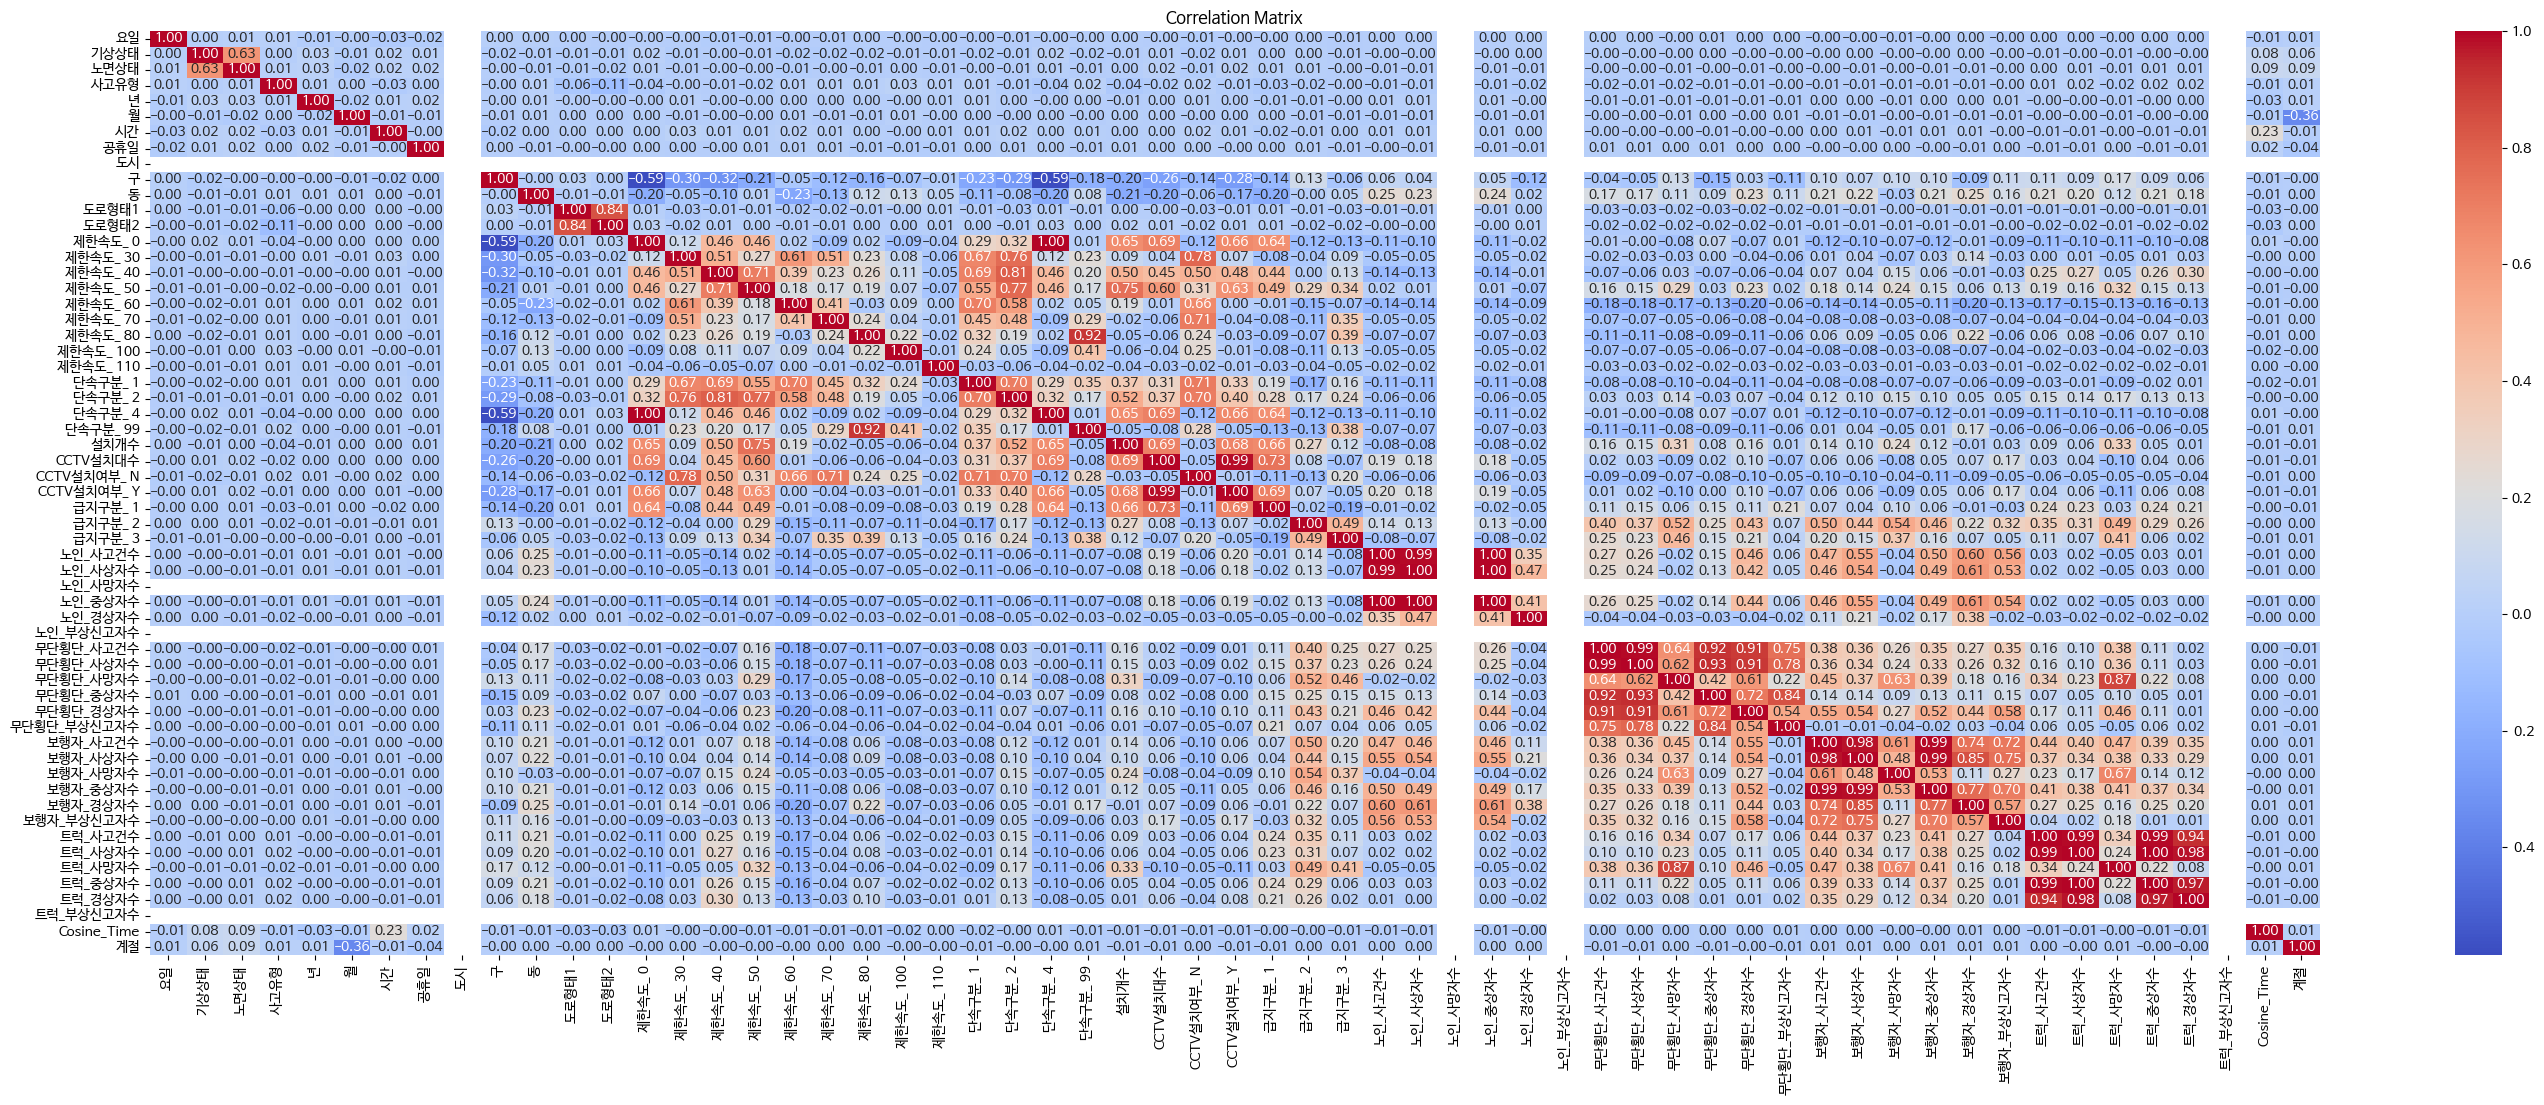

In [ ]:
corr = train_x.corr()

# 상관관계 행렬 시각화
plt.figure(figsize=(35, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [14]:
train_x = train_x[['기상상태','노면상태','사고유형','구','동','도로형태1','요일','년','월','시간', '제한속도_ 60', '제한속도_ 70',
                   '제한속도_ 80', '제한속도_ 100', '제한속도_ 110', '단속구분_ 2', '단속구분_ 4', '설치개수', 'CCTV설치대수',
                   '급지구분_ 2', '급지구분_ 3', '공휴일', '노인_사고건수', '무단횡단_사고건수', '보행자_사고건수','트럭_사고건수', 'Cosine_Time', '계절']]
test_x = test_x[['기상상태','노면상태','사고유형','구','동','도로형태1','요일','년','월','시간', '제한속도_ 60', '제한속도_ 70',
                   '제한속도_ 80', '제한속도_ 100', '제한속도_ 110', '단속구분_ 2', '단속구분_ 4', '설치개수', 'CCTV설치대수',
                   '급지구분_ 2', '급지구분_ 3', '공휴일', '노인_사고건수', '무단횡단_사고건수', '보행자_사고건수','트럭_사고건수', 'Cosine_Time', '계절']]

In [ ]:
display(train_x.head())
display(test_x.head())

,기상상태,노면상태,사고유형,구,동,도로형태1,요일,년,월,시간,...,CCTV설치대수,급지구분_ 2,급지구분_ 3,공휴일,노인_사고건수,무단횡단_사고건수,보행자_사고건수,트럭_사고건수,Cosine_Time,계절
0,2,0,0,7,40,2,6,2019,1,0,...,13.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1.000000,1
1,5,0,0,1,4,2,6,2019,1,0,...,0.0,1.0,3.0,1,0.0,0.0,0.0,0.0,1.000000,1
2,2,0,0,6,66,2,6,2019,1,1,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.965926,1
3,2,0,1,4,79,2,6,2019,1,2,...,32.0,9.0,5.0,1,0.0,0.0,0.0,0.0,0.866025,1
4,2,0,1,3,129,2,6,2019,1,4,...,10.0,3.0,0.0,1,0.0,0.0,0.0,0.0,0.500000,1


,기상상태,노면상태,사고유형,구,동,도로형태1,요일,년,월,시간,...,CCTV설치대수,급지구분_ 2,급지구분_ 3,공휴일,노인_사고건수,무단횡단_사고건수,보행자_사고건수,트럭_사고건수,Cosine_Time,계절
0,2,0,0,6,99,0,5,2022,1,1,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,9.659258e-01,1
1,2,0,0,6,168,2,5,2022,1,1,...,0.0,0.0,2.0,1,5.0,0.0,0.0,0.0,9.659258e-01,1
2,2,0,1,6,117,0,5,2022,1,4,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,5.000000e-01,1
3,2,0,1,6,126,2,5,2022,1,4,...,0.0,2.0,1.0,1,0.0,0.0,0.0,0.0,5.000000e-01,1
4,2,0,1,1,4,0,5,2022,1,6,...,0.0,1.0,3.0,1,0.0,0.0,0.0,0.0,6.123234e-17,1


In [15]:
train0 = train_x[train_x.사고유형 == 0]
train0.drop(['사고유형'], axis=1)

train1 = train_x[train_x.사고유형 == 1]
train1.drop(['사고유형'], axis=1)

train2 = train_x[train_x.사고유형 == 2]
train2.drop(['사고유형'], axis=1)

test0 = test_x[test_x.사고유형 == 0]
test0.drop(['사고유형'], axis=1)

test1 = test_x[test_x.사고유형 == 1]
test1.drop(['사고유형'], axis=1)

test2 = test_x[test_x.사고유형 == 2]
test2.drop(['사고유형'], axis=1)

train_y0 = train_y[train0.index]
train_y1 = train_y[train1.index]
train_y2 = train_y[train2.index]

- 사고유형별 XGB

In [39]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error


# TimeSeriesSplit 설정
time_series_cv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'n_estimators': [30, 50, 70, 100],
    'max_depth': range(3,10,3)
}

def get_rmsle(y_actual, y_pred):
    return np.sqrt(mean_squared_log_error(y_actual, y_pred))

rmsle_scorer = make_scorer(get_rmsle, greater_is_better=False)

xgb_model = XGBRegressor()

final_pred_df = pd.DataFrame()

for index, (x, y, z) in enumerate(zip([train0, train1, train2], [train_y0, train_y1, train_y2], [test0, test1, test2])):
    grid_search = GridSearchCV(xgb_model, param_grid, cv=time_series_cv, scoring=rmsle_scorer)
    grid_search.fit(x, y)

    best_xgb_model = grid_search.best_estimator_
    print(abs(grid_search.best_score_))

    pred = best_xgb_model.predict(z)
    pred[pred < 0] = 0

    pred_df = pd.DataFrame({'Index': z.index, 'Prediction': pred})

    final_pred_df = pd.concat([final_pred_df, pred_df])

final_pred_df.sort_values(by='Index', inplace=True)

# print(final_pred_df)

0.3637237900541883
0.4788449991433228
0.6087792760642715


In [ ]:
final_pred_df.reset_index(inplace=True)
pred_eclo = final_pred_df.Prediction
pred_eclo.head()

0    3.899727
1    3.836071
2    6.257522
3    5.036376
4    5.144589
Name: Prediction, dtype: float32

- 사고유형별 catboost

In [40]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np
import pandas as pd

import random
random.seed(0)

# TimeSeriesSplit 설정
time_series_cv = TimeSeriesSplit(n_splits=5)


param_grid = {
    'iterations': [30, 50, 70, 100],  # 트리 개수 설정
    'depth':range(3,10,3)
    }

def get_rmsle(y_actual, y_pred):
    return np.sqrt(mean_squared_log_error(y_actual, y_pred))

rmsle_scorer = make_scorer(get_rmsle, greater_is_better=False)

cat_model = CatBoostRegressor(verbose=0)

final_pred_df = pd.DataFrame()

for index, (x, y, z) in enumerate(zip([train0, train1, train2], [train_y0, train_y1, train_y2], [test0, test1, test2])):
    grid_search = GridSearchCV(cat_model, param_grid, cv=time_series_cv, scoring=rmsle_scorer)
    grid_search.fit(x, y)

    best_cat_model = grid_search.best_estimator_
    print(np.sqrt(grid_search.best_score_ * -1))

    pred = best_cat_model.predict(z)
    pred[pred < 0] = 0

    pred_df = pd.DataFrame({'Index': z.index, 'Prediction': pred})

    final_pred_df = pd.concat([final_pred_df, pred_df])

final_pred_df.sort_values(by='Index', inplace=True)

print(final_pred_df)

0.6018570366800549
0.6916420009510551
0.7630028670639954
      Index  Prediction
0         0    3.920290
1         1    3.844167
0         2    6.204700
1         3    5.569693
2         4    5.281611
...     ...         ...
8554  10958    4.565182
8555  10959    4.918264
8556  10960    5.326613
8557  10961    5.037591
8558  10962    5.274366

[10963 rows x 2 columns]


In [ ]:
final_pred_df.reset_index(inplace=True)
pred_eclo = final_pred_df.Prediction
pred_eclo.head()

0    3.920290
1    3.844167
2    6.204700
3    5.569693
4    5.281611
Name: Prediction, dtype: float64

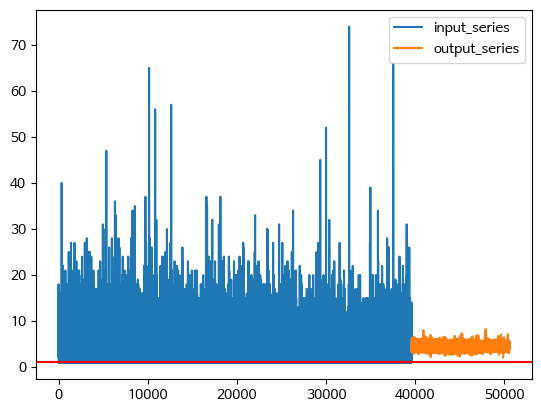

In [ ]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)), y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()


plot_series(train_y, pred_eclo)
plt.show()